# Figure 6: Direct comparison of overall model performance

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @author: Sebastian Gegenleithner, Manuel Pirker

## Imports

In [2]:
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias

import numpy as np
import pandas as pd

import json


## Functions

In [3]:
def find_best_models(data_lstm, data_arima):
    
    all_best = []
    normalized_arima = []
    normalized_lstm = []
    normalized_hydro = []
    
    all_absolute_errors_arima = []
    all_absolute_errors_lstm = []
    

    for i in range(0,96):
        arima_q0 = data_arima['fc%s' % i].values
        lstm_q0 = data_lstm['q%s' % i].values
        measured_q0 = data_arima['obs%s' % i].values
        
        num_best_arima = 0
        num_best_lstm = 0
        num_best_hydro = 0
        
        all_abs_error = []
        all_abs_error2 = []

        for j in range(0,len(arima_q0)):
            error_arima = abs(measured_q0[j] - arima_q0[j])
            error_lstm = abs(measured_q0[j] - lstm_q0[j])
            
            if error_arima < error_lstm:
                num_best_arima += 1
            if error_lstm < error_arima:
                num_best_lstm += 1
                
            
            all_abs_error.append(error_arima)
            all_abs_error2.append(error_lstm)

        all_absolute_errors_arima.append(all_abs_error)
        all_absolute_errors_lstm.append(all_abs_error2)

        list_best = [num_best_arima, num_best_lstm]
        
    
        all_best.append(list_best)
    
        normalized_arima.append(num_best_arima / (num_best_arima + num_best_lstm))
        normalized_lstm.append(num_best_lstm / (num_best_arima + num_best_lstm))
        normalized_hydro.append(num_best_hydro / (num_best_arima + num_best_lstm))
    
    return all_best, np.asarray(normalized_arima), np.asarray(normalized_lstm), all_absolute_errors_arima,all_absolute_errors_lstm

## Create model class

In [4]:
class Model:
    def __init__(self, name, model_folder, n_trial=-1, target_name="", feat_hindcast=[], feat_forecast=[], is_external_model= False, is_final_model= False, color="r", ls="-"):
        self.name  = name
        self.color = color
        self.ls    = ls
        self.is_external_model = is_external_model
        
        if is_final_model:
            self.lg_path = model_folder
            self.hp_path = model_folder
            if is_external_model:
                is_external_model
                # do nothing
            else:
                with open(os.path.join(self.lg_path, "features.txt"), "r") as f:
                    dic = json.load(f)
                self.target_name   = dic["target_name"]
                self.feat_hindcast = dic["feat_hindcast"]
                self.feat_forecast = dic["feat_forecast"]
        else:
            self.lg_path = os.path.join(model_folder, "log", f"trial_{n_trial:02d}")
            self.hp_path = os.path.join(model_folder,  "hp", f"trial_{n_trial:02d}")
            self.target_name   = target_name
            self.feat_hindcast = feat_hindcast
            self.feat_forecast = feat_forecast

models = {
    "arima": Model("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "k",
                ls = "--",
                  ),
    "lstm_pbhm": Model("HLSTM-PBHM",
                           r"rst\HLSTM-PBHM",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          ),
     "lstm": Model("HLSTM",
                   r"rst\HLSTM",
                   is_final_model = True,
                   color = "#ff7f00",
                   ls = "-",
                 ),
     }
        

## Init

In [5]:
# path
PLOT_PATH = r"plots"
DATA_PATH = r"data\Dataset.csv"

# set plot parameters
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

## Main

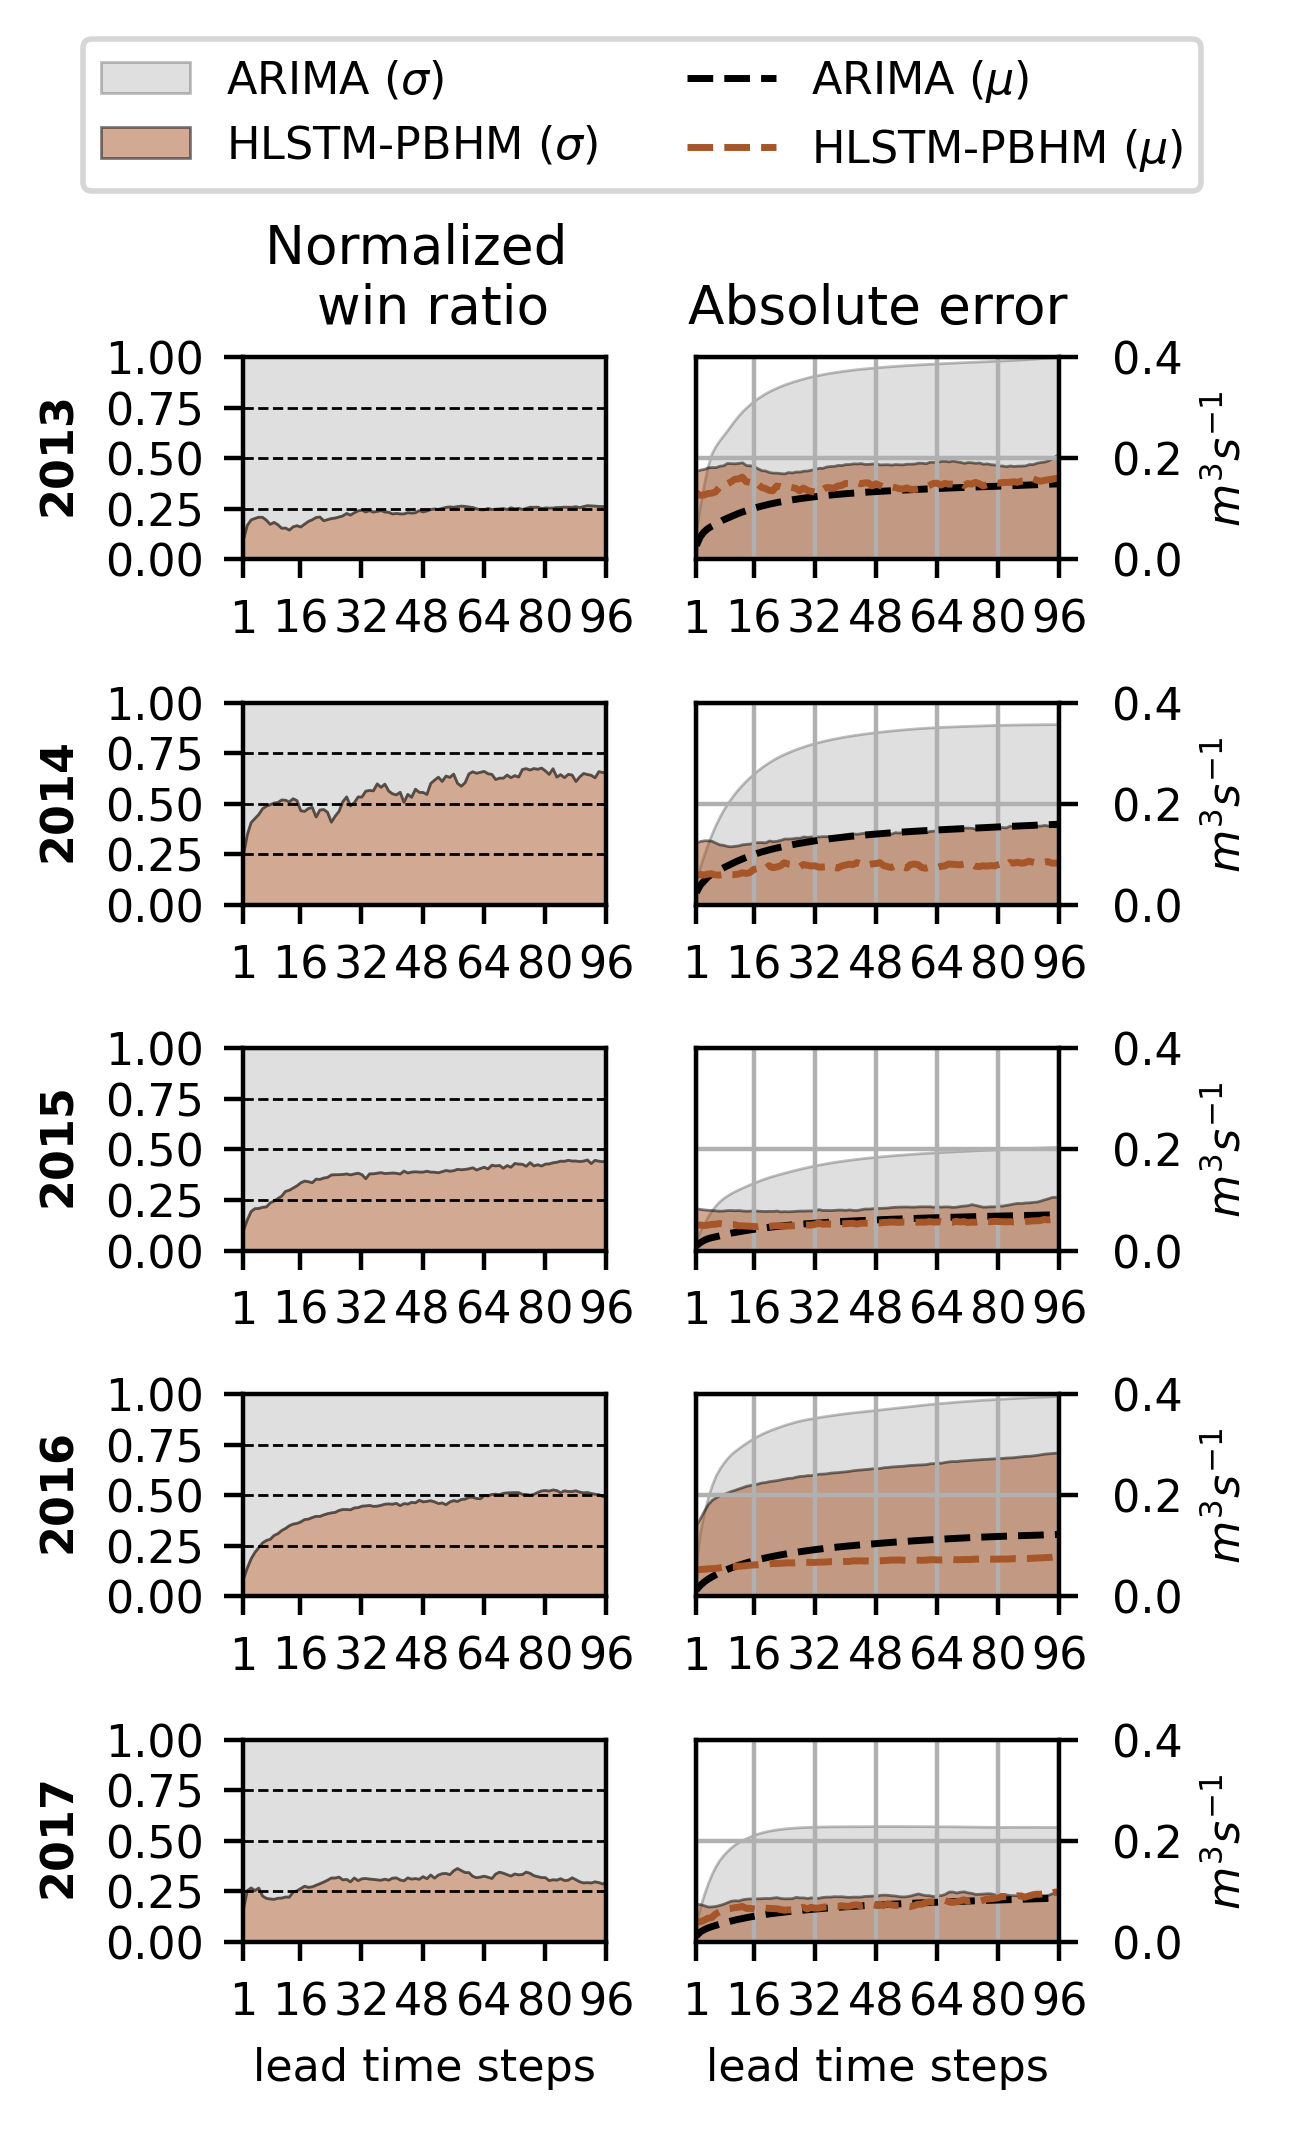

In [6]:
# create summary dataframe
df = pd.DataFrame(index=np.arange(2013,2018,dtype=int))

# process all folds
filepaths_lstm = [os.path.join(models["lstm_pbhm"].lg_path, f"forecast_{x:d}.pckl") for x in range(2013,2018)]

filepaths_arima = [os.path.join(models["arima"].lg_path, f"forecast_{x:d}.pckl") for x in range(2013,2018)]

date_ranges = [['2013-01-06 00:00:00','2013-12-27 00:00:00'],
               ['2014-01-06 00:00:00','2014-12-27 00:00:00'],
               ['2015-01-06 00:00:00','2015-12-27 00:00:00'],
               ['2016-01-06 00:00:00','2016-12-27 00:00:00'],
               ['2017-01-06 00:00:00','2017-12-27 00:00:00']]

all_error_folds_arima = []
all_error_folds_lstm = []
all_norm_arima = []
all_norm_hydro = []
all_norm_lstm = []

for i in range(0,len(filepaths_lstm)):
    year = 2013 + i

    data_lstm = pd.read_pickle(filepaths_lstm[i])
    data_arima = pd.read_pickle(filepaths_arima[i])
    
    # FIX UTC ------------------------------------------------------
    data_arima.index = pd.date_range(data_arima.index[0], data_arima.index[-1], freq="15min", tz="UTC")

    data_lstm_filtered = data_lstm.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]
    data_arima_filtered = data_arima.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]

    all_best_list, normalized_arima, normalized_lstm, all_errors_arima, all_errors_lstm = find_best_models(data_lstm_filtered, data_arima_filtered)

    all_error_folds_arima.append(all_errors_arima)
    all_error_folds_lstm.append(all_errors_lstm)
    all_norm_arima.append(normalized_arima)
    all_norm_lstm.append(normalized_lstm)
    
    # percentage of ARIMA wins
    add_up = np.sum(all_best_list, axis=0)
    df.loc[year, "arima_first_step_wins_percent"] = all_best_list[0][0] / np.sum(all_best_list, axis=1)[0]
    df.loc[year, "arima_wins_percent"] = add_up[0] / np.sum(add_up)
    # lead time steps to outperform ARIMA in direct wins
    out_perform_idxs = [n for n, (x,y) in enumerate(all_best_list) if y-x > 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "wins"]       = out_perform_idxs[0]
        df.loc[year, "wins_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "wins"]       = -1
        df.loc[year, "wins_hours"] = -1
    # lead time steps to outperform ARIMA in AE
    out_perform_idxs = [n for n, (x,y) in enumerate(zip(
            np.mean(all_errors_arima, axis=1), 
            np.mean(all_errors_lstm, axis=1)
        )) if y-x < 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "ae"]       = out_perform_idxs[0]
        df.loc[year, "ae_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "ae"]       = -1
        df.loc[year, "ae_hours"] = -1
    # lead time steps to outperform ARIMA in sigma
    out_perform_idxs = [n for n, (x,y) in enumerate(zip(
            np.std(all_errors_arima, axis=1), 
            np.std(all_errors_lstm, axis=1)
        )) if y-x < 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "sigma"]       = out_perform_idxs[0]
        df.loc[year, "sigma_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "sigma"]       = -1
        df.loc[year, "sigma_hours"] = -1
 
fig, axes = plt.subplots(5,2,figsize=(4.72*8.3/12,5), dpi=400)

num_entries = 96

x_values = np.arange(1,97)

k = 0
for i in range(0,5):
        
    x = np.arange(1,97)
    y_mean = np.asarray([np.mean(elem) for elem in all_error_folds_arima[k]])
    y_std = np.asarray([np.std(elem) for elem in all_error_folds_arima[k]])
    
    y_mean_lstm = np.asarray([np.mean(elem) for elem in all_error_folds_lstm[k]])
    y_std_lstm = np.asarray([np.std(elem) for elem in all_error_folds_lstm[k]])
    
    axes[i,1].plot(x, y_mean, color='black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std, y2=0,  color='grey', label='ARIMA', alpha=0.25, edgecolor='black', linewidth=0.5)
    
    axes[i,1].plot(x, y_mean_lstm, color='#a65628', linestyle = '--', label='LSTM-PBHM ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std_lstm, y2=0, color='#a65628', label='HLSTM-PBHM', alpha=0.5, edgecolor='black', linewidth=0.5)
    
    axes[i,1].set_xticks(np.array([1,16,32,48,64,80,96]))
    axes[i,1].set_yticks(np.array([0.0,0.2,0.4]))
    axes[i,1].set_ylim(0,0.4)
    axes[i,1].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
    #axes[i, j].set_ylim(-0.05, 1.05)
    axes[i,1].set_xlim(1, 96)
    #axes[i,j].set_yticks([0, 0.25,0.5,0.75,1.0])
    axes[i,1].grid()
    
    axes[i,1].yaxis.set_major_formatter('{x: 4.1f}')
    axes[i,1].set_ylabel("$m^3s^{-1}$")
    #axes[i,1].set_ylabel("$m^3/s$")
    axes[i,1].yaxis.set_label_position("right")
    axes[i,1].yaxis.set_ticks_position("right")
    
    k += 1
    
k = 0
for i in range(0,5):
   
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=1, label='ARIMA ($\sigma$)', color = 'grey',edgecolor='black', linewidth=0.5, alpha=0.25)
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=0, label='HLSTM-PBHM ($\sigma$)', color = '#a65628',edgecolor='black', linewidth=0.5, alpha=0.5)

    axes[i,0].plot([], [], color= 'black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,0].plot([], [], color= '#a65628', linestyle = '--', label='HLSTM-PBHM ($\mu$)', linewidth=1.25)

    axes[i,0].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")
   # axes[i,0].set_ylabel(r"$\bf{"+f"fold\ {2013 + i}"+r"}$")
    axes[i,0].set_xticks(np.array([1, 16,32,48,64,80,96]))
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
    axes[i,0].set_ylim(0, 1)
    axes[i,0].set_xlim(1, 96)
    axes[i,0].set_yticks([0, 0.25,0.5,0.75,1.0])
    axes[i,0].grid(axis='y', linestyle='--', color='black', linewidth=0.5)

    k += 1

axes[4,0].set_xlabel('lead time steps')
axes[4,1].set_xlabel('lead time steps')
#axes[0,0].set_title('Normalized number \n of best model results')
axes[0,0].set_title('Normalized \n win ratio')
axes[0,1].set_title("Absolute error")

plt.tight_layout()
plt.subplots_adjust(top=0.89)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.6),
                 # title=r'$\bf{Direct \ comparison \ between \ correction \ schemes \ - \ Overall}$',
                  loc='lower center', ncol=2, 
                  borderaxespad=1)

In [7]:
fig.savefig(os.path.join(PLOT_PATH, 'fig6_directandband_annual_ae.png'), bbox_inches="tight", dpi=300)

## Dataframe results
used in cp. 4.1.3 line 279-286

In [8]:
df

,arima_first_step_wins_percent,arima_wins_percent,wins,wins_hours,ae,ae_hours,sigma,sigma_hours
2013,0.900091,0.768771,-1.0,-1.00,-1.0,-1.00,3.0,0.75
2014,0.751298,0.427807,8.0,2.00,5.0,1.25,4.0,1.00
2015,0.897744,0.623199,-1.0,-1.00,23.0,5.75,5.0,1.25
2016,0.910964,0.557922,63.0,15.75,11.0,2.75,3.0,0.75
2017,0.835275,0.696602,-1.0,-1.00,47.0,11.75,2.0,0.50
